In [87]:
# Libraries
from ngsolve import *
from netgen.geom2d import SplineGeometry
import scipy.linalg
import scipy.sparse as sp
import numpy as np
from ngsolve.webgui import Draw
from helping_functions import *
import matplotlib.pyplot as plt


from ngsolve.webgui import Draw


In [88]:
SetNumThreads(4)


In [89]:
# Setting the geometry

geo = SplineGeometry()
# Setting global decomposition vertices (coarse mesh)
Points = [(0,0), (1,0), (2,0), 
          (2,1), (1,1), (0,1)]
# Setting edgle lables counter-clock wise 
bcs_edge = ["bottom0", "bottom1", "right", "top1", "top0", "left", "middle"]
# Labeling vertices V1,...,V6
for i, pnt in enumerate(Points):
    geo.AddPoint(*pnt, name = "V" + str(i))
    
# Labeling edges by specifying end points, neighbouring domains (counterclock-wise), label
geo.Append(["line", 0, 1], leftdomain=1, rightdomain=0, bc="bottom0")
geo.Append(["line", 1, 2], leftdomain=2, rightdomain=0, bc="bottom1")
geo.Append(["line", 2, 3], leftdomain=2, rightdomain=0, bc="right")
geo.Append(["line", 3, 4], leftdomain=2, rightdomain=0, bc="top1")
geo.Append(["line", 4, 5], leftdomain=1, rightdomain=0, bc="top0")
geo.Append(["line", 5, 0], leftdomain=1, rightdomain=0, bc="left")
geo.Append(["line", 1, 4], leftdomain=1, rightdomain=2, bc="middle")

# ngmesh = unit_square.GenerateMesh(maxh=0.1)
mesh = Mesh(geo.GenerateMesh(maxh = 0.1))
# Labeling subdomains in coarse mesh
mesh.ngmesh.SetMaterial(1,"omega0")
mesh.ngmesh.SetMaterial(2,"omega1")
Draw(mesh)
print(mesh.nv) # Number of vertices?
print(mesh.GetMaterials()) # Subdomains
print(mesh.GetBoundaries()) # Edges
print(mesh.GetBBoundaries()) # Vertices
#input()

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

261
('omega0', 'omega1')
('bottom0', 'bottom1', 'right', 'top1', 'top0', 'left', 'middle')
('V0', 'V1', 'V2', 'V3', 'V4', 'V5')


In [84]:
#######################################################################
###### BUBBLES AND EDGE MODES CONVERGENCE 
# DEGREE OF APPROXIMATION CONVERGENCE
#######################################################################


# SYSTEM ASSEMBLY
h1_error = []
order_v = [2,3] # ATTENTION: There is an error for order=1
             # Cannot use scipy.linalg.eig for sparse A with k >= N - 1.
max_bm = 100
max_em = 10
Bubble_modes = [50]
Edge_modes = [1,10] #CAREFUL: we have a limited number of edge modes due to the mesh size
# Should redefine max_em

with TaskManager():
    for order in order_v:
    
        V =  H1(mesh, order = order, dirichlet = ".*")
        gfu = GridFunction(V)
    
        acms = ACMS(order = order, mesh = mesh, bm = max_bm, em = 10)
        acms.CalcHarmonicExtensions()
    
        u, v = V.TnT()
        dom_bnd = "bottom0|bottom1|right|top1|top0|left"

        kappa = 0
        a = BilinearForm(V)
        a += grad(u) * grad(v) * dx
        a += - kappa * u * v * dx
        a += 10**6 * u * v * ds(dom_bnd)
        # a += u * v * dx
        a.Assemble()

        f = LinearForm(V)
        f += 1 * v * dx()
        f.Assemble()
        ainv = a.mat.Inverse()
        gfu_ex = GridFunction(V)
        gfu_ex.vec.data = ainv * f.vec
    
        print(order)
        
        
        basis_v = MultiVector(gfu.vec, 0)
        basis_e = MultiVector(gfu.vec, 0)
        basis_b = MultiVector(gfu.vec, 0)

        acms.calc_vertex_basis(basis_v)
        acms.calc_edge_basis(basis_e)
        acms.calc_bubble_basis(basis_b)
    
        for EM in Edge_modes:
            for BM in Bubble_modes:
                basis = MultiVector(gfu.vec, 0)
                for bv in basis_v:
                    basis.Append(bv)

                for e, label in enumerate(mesh.GetBoundaries()):
                    for i in range(EM):
                        basis.Append(basis_e[e * max_em + i])
        
        
                for d, dom in enumerate(mesh.GetMaterials()):
                    for i in range(BM):
                        basis.Append(basis_b[d * max_bm + i])


                num = len(basis)

                asmall = InnerProduct (basis, a.mat * basis)
                ainvsmall = Matrix(num,num)

                f_small = InnerProduct(basis, f.vec)

                asmall.Inverse(ainvsmall)
                usmall = ainvsmall * f_small

                gfu.vec[:] = 0.0

                gfu.vec.data = basis * usmall


                ### big solution

                grad_uex = Grad(gfu_ex)
                diff = grad_uex - Grad(gfu)

                h1_error_aux = sqrt( Integrate ( InnerProduct(diff,diff), mesh, order = 10))

                h1_error.append(h1_error_aux)
            
            
h1_error = np.reshape(h1_error, (len(order_v)*len(Edge_modes), len(Bubble_modes)))
print(h1_error)


3
4
5
6
[[0.01834728]
 [0.01004017]
 [0.01835162]
 [0.01004801]
 [0.01835198]
 [0.01004868]
 [0.01831197]
 [0.00997541]]


Text(0.5, 0, 'Bubbles')

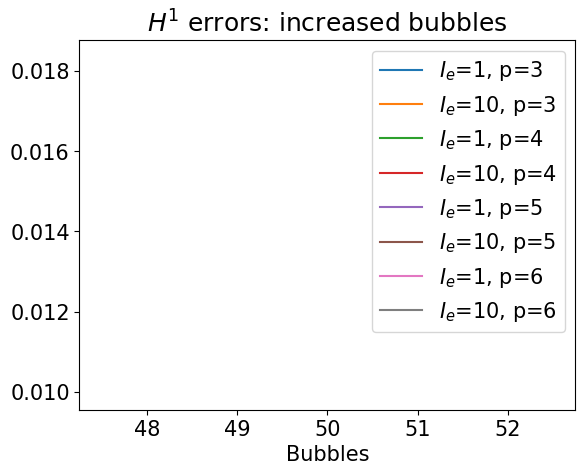

In [85]:
## PLOT ERROR with increased BUBBLE modes for different DEGREES of approximation
plt.rcParams.update({'font.size':15})
for d in range(len(order_v)):
    for i in range(len(Edge_modes)):
        plt.plot(Bubble_modes, h1_error[d*len(Edge_modes) + i,:], label=('$I_e$=%i, p=%i' %(Edge_modes[i],order_v[d])))
plt.title('$H^1$ errors: increased bubbles')
plt.legend()
plt.xlabel('Bubbles')

Text(0.5, 0, 'Edge modes')

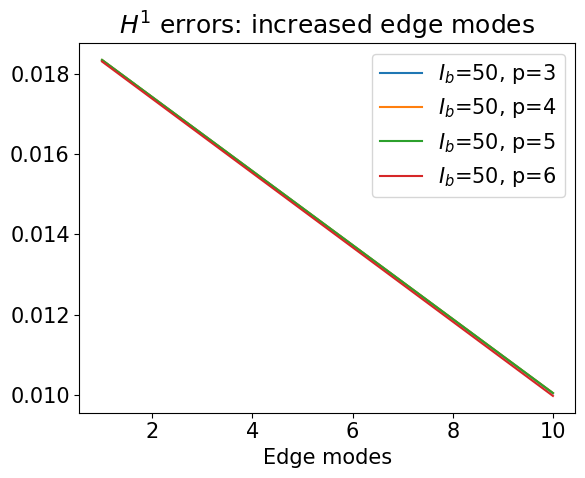

In [90]:
## PLOT ERROR with increased EDGE modes for different DEGREES of approximation
plt.rcParams.update({'font.size':15})
for d in range(len(order_v)):
    for i in range(len(Bubble_modes)):
        plt.plot(Edge_modes, h1_error[d*len(Edge_modes) : d*len(Edge_modes) + len(Edge_modes),i], label=('$I_b$=%i, p=%i' %(Bubble_modes[i],order_v[d])))
plt.title('$H^1$ errors: increased edge modes')
plt.legend()
plt.xlabel('Edge modes')

**Old code without degree of approximation - bubbles and edge modes convergence**

In [ ]:
#######################################################################
###### BUBBLES AND EDGE MODES CONVERGENCE
#######################################################################
# SYSTEM ASSEMBLY
h1_error = []
order = 3
max_bm = 100
max_em = 10
Bubble_modes = [50,60,70,80,90]
Edge_modes = [1,5,10] #CAREFUL: we have a limited number of edge modes due to the mesh size
# Should redefine max_em

with TaskManager():
    V =  H1(mesh, order = order, dirichlet = ".*")
    gfu = GridFunction(V)
    
    acms = ACMS(order = order, mesh = mesh, bm = max_bm, em = 10)
    acms.CalcHarmonicExtensions()
    
    u, v = V.TnT()
    dom_bnd = "bottom0|bottom1|right|top1|top0|left"

    kappa = 0
    a = BilinearForm(V)
    a += grad(u) * grad(v) * dx
    a += - kappa * u * v * dx
    a += 10**6 * u * v * ds(dom_bnd)
    # a += u * v * dx
    a.Assemble()

    f = LinearForm(V)
    f += 1 * v * dx()
    f.Assemble()
    ainv = a.mat.Inverse()
    gfu_ex = GridFunction(V)
    gfu_ex.vec.data = ainv * f.vec
    
    basis_v = MultiVector(gfu.vec, 0)
    basis_e = MultiVector(gfu.vec, 0)
    basis_b = MultiVector(gfu.vec, 0)

    acms.calc_vertex_basis(basis_v)
    acms.calc_edge_basis(basis_e)
    acms.calc_bubble_basis(basis_b)
    
    for EM in Edge_modes:
        for BM in Bubble_modes:
            basis = MultiVector(gfu.vec, 0)
            for bv in basis_v:
                basis.Append(bv)

            for e, label in enumerate(mesh.GetBoundaries()):
                for i in range(EM):
                    basis.Append(basis_e[e * max_em + i])
        
        
            for d, dom in enumerate(mesh.GetMaterials()):
                for i in range(BM):
                    basis.Append(basis_b[d * max_bm + i])


            num = len(basis)
            
            
            asmall = InnerProduct (basis, a.mat * basis)
            ainvsmall = Matrix(num,num)

            f_small = InnerProduct(basis, f.vec)

            # print(asmall)
            asmall.Inverse(ainvsmall)
            usmall = ainvsmall * f_small

            gfu.vec[:] = 0.0

            gfu.vec.data = basis * usmall


            ### big solution

            grad_uex = Grad(gfu_ex)
            diff = grad_uex - Grad(gfu)

            h1_error_aux = sqrt( Integrate ( InnerProduct(diff,diff), mesh, order = 10))

            h1_error.append(h1_error_aux)
            
            
h1_error = np.reshape(h1_error, (len(Edge_modes), len(Bubble_modes)))
print(h1_error)


In [ ]:
## PLOT ERROR with increased BUBBLE functions
plt.rcParams.update({'font.size':15})
#plt.figure(figsize=(8,8))
for i in range(len(Edge_modes)):
    plt.plot(Bubble_modes, h1_error[i,:], label=('Edge modes=%i' %Edge_modes[i]))
plt.title('$H^1$ errors: increased bubbles deg=%i' %order)
plt.legend()
plt.xlabel('Bubbles')

In [ ]:
## PLOT ERROR with increased EDGE modes
plt.rcParams.update({'font.size':15})
#plt.figure(figsize=(8,8))
for i in range(len(Bubble_modes)):
    plt.plot(Edge_modes, h1_error[:,i], label=('Bubbles=%i' %Bubble_modes[i]))
plt.title('$H^1$ errors: increased edge modes deg=%i' %order)
plt.legend()
plt.xlabel('Edge modes')

**Old code with comments - now shifted to helping_functions**

In [ ]:
# Basis functions per subdomains (constant for all subdomains)
bubble_modes = 5
edge_modes = 5

# Definition of Sobolev space, order of polynomial approximation can be increased
# The Dirichlet condition is imposed everywhere because it will be needed for the basis construction
# It does not effectively remove the boundary nodes
order = 2 # Polynomial degree of approximation
V = H1(mesh, order = order, dirichlet = ".*")

gfu = GridFunction(V)


**Extension operators**

We need an extension from $\Gamma$ to $\Omega$, which is obtained by combining the extensions of functions from $\partial\Omega_j$ to $\Omega_j$.

For a given $\tau \in H^{1/2}(\partial \Omega_j)$, let $\tilde \tau \in H^1(\Omega_j)$ be any function satisfying $\tilde\tau_{\mid\partial\Omega_j}=\tau$.
Then, we indicate by $\tilde\tau_0 \in H_0^1(\Omega_j)$ the solution to

\begin{align} 
    \mathcal{A}_{j} (\tilde\tau_0, v)-(\kappa^2 \tilde\tau_0, v)_{\Omega_j} = -\left(\mathcal{A}_j(\tilde\tau,v)-(\kappa^2 \tilde\tau, v)_{\Omega_j}\right) \quad \forall  v\in  H_0^1(\Omega_j).
\end{align}

We characterize the $\mathcal{A}$-harmonic extension $E^{j}:H^{1/2}(\partial \Omega_j) \to H^1(\Omega_j)$ by setting 
    $E^{j}\tau := \tilde\tau+\tilde\tau_0$.

**Lemma** The extension operator $E^{j}:H^{1/2}(\partial \Omega_j) \to H^1(\Omega_j)$ is bounded, that is,
    \begin{equation}
        \|E^{j}\tau\|_{\mathcal{B}}\leq (1+\frac{1}{\beta^j})\|\tilde\tau\|_{\mathcal{B}},
    \end{equation}
    where $\tilde \tau\in H^1(\Omega_j)$ is any extension of $\tau\in \ H^{1/2}(\partial \Omega_j)$.
    

We note the following orthogonality relation, which is a crucial property for the construction of the ACMS  spaces: for all bubble functions $b_i^j \in H_0^1(\Omega_j)$, we have
\begin{align}
		\mathcal{A}_{j}(E^j \tau,b_i^j)-(\kappa^2 E^j \tau,b_i^j)_{\Omega_j}=0.
\end{align}

Assume that $e=\partial\Omega_j \cap \partial\Omega_i\in \mathcal{E}$ is a common edge of $\Omega_i$ and $\Omega_j$. Let $\tau \in H^{1/2}(\Gamma)$, which, by restriction, implies $\tau\in H^{1/2}(\partial \Omega_j)$ and $\tau\in H^{1/2}(\partial \Omega_i)$.


Extension on interface: $E^{\Gamma} : H^{1/2}(\Gamma) \to H^1_D(\Omega)$ by $(E^{\Gamma} \tau)_{\mid\Omega_j} = E^{j} \tau_{\mid \partial \Omega_j}$, for all $j = 1,\ldots,J$. 

Extension on edges: $E^{\Gamma} : H^{1/2}_{00}(e) \to H^1_D(\Omega)$ via $E^{\Gamma} \tau = E^{\Gamma} E_0^e\tau$, where $E_0^e: H^{1/2}_{00}(e)  \to H^{1/2}(\Gamma)$ denotes the extension by zero to the interface $\Gamma$.


In [ ]:
dom_name = 'omega0'
fd_all = V.GetDofs(mesh.Materials(dom_name)) # Dofs of specific domain
base_space = H1(mesh, order = order, dirichlet = ".*") #Replicate H^1_0 on subdomain
Vharm = Compress(base_space, fd_all) # Restriction to specified dofs
uharm, vharm = Vharm.TnT() # Trial and test functions
aharm = BilinearForm(Vharm)
#Setting bilinear form:  int (Grad u Grad v) d\Omega_j
aharm += grad(uharm)*grad(vharm)*dx(dom_name)
aharm.Assemble()
# Homogeneous Dirichlet bc because we select FreeDofs (only internal dofs)
aharm_inv = aharm.mat.Inverse(Vharm.FreeDofs(), inverse = "sparsecholesky")

In [ ]:
import matplotlib
import matplotlib.pylab as plt


In [ ]:
###############################################################
# EXTENSIONS

edge_extensions = {}
vol_extensions = {}

# Define harmonic extension on specific subdomain
# Returns the Sobolev space H^1_0(\Omega_j), the stiffness matrix and its inverse
def GetHarmonicExtensionDomain(dom_name):
    fd_all = V.GetDofs(mesh.Materials(dom_name)) # Dofs of specific domain
    base_space = H1(mesh, order = order, dirichlet = ".*") #Replicate H^1_0 on subdomain
    Vharm = Compress(base_space, fd_all) # Restriction to specified dofs
    uharm, vharm = Vharm.TnT() # Trial and test functions
    aharm = BilinearForm(Vharm)
    #Setting bilinear form:  int (Grad u Grad v) d\Omega_j
    aharm += grad(uharm)*grad(vharm)*dx(dom_name)
    aharm.Assemble()
    # Homogeneous Dirichlet bc because we select FreeDofs (only internal dofs)
    aharm_inv = aharm.mat.Inverse(Vharm.FreeDofs(), inverse = "sparsecholesky")

    # Calc embedding - Local to global mapping
    # Computes global indices of local dofs 
    ind = Vharm.ndof * [0]
    ii = 0 # ii = index of local dofs
    for i, b in enumerate(fd_all): # i = index of global dofs
        if b == True: # If I am on a local dof -> save it and increase counter
            ind[ii] = i
            ii += 1
    E = PermutationMatrix(base_space.ndof, ind) # NGSolve for contructing mapping

    return Vharm, aharm.mat, aharm_inv, E


# Define harmonic extension on specific subdomain
# Returns the Sobolev space H^{1/2}_00(e), the stiffness matrix and its inverse
def GetHarmonicExtensionEdge(edge_name):
    fd_all = V.GetDofs(mesh.Boundaries(edge_name)) # Dofs of specific edge
    bnd = "" # Initialize empty boundary 
    # The space construction requires bc specified on the full domain 
    # so first we set Dirichlet everywhere and then remove internal vertices on our edge
    # This gives the edge vertices with Dirichlet bc
    for b in mesh.GetBoundaries():
        if (b != edge_name): # If the edge is not our specified edge, then add it to bnd
            bnd += b + "|"
    bnd = bnd[:-1] # Remove the last added "|" - unnecessary
    base_space = H1(mesh, order = order, dirichlet = bnd)
    
    #Setting bilinear form:  int (Grad u Grad v) d"e". 
    Vharm = Compress(base_space, fd_all) #Sobolev space H^{1/2}_00(e)
    t = specialcf.tangential(2) # Object to be evaluated - Tangential vector along edge (2=dimension)
    uharm, vharm = Vharm.TnT()
    aharm = BilinearForm(Vharm)
    aharm += (grad(uharm)*t) * (grad(vharm)*t) * ds(skeleton = True, definedon=mesh.Boundaries(edge_name))
    aharm.Assemble()
    # Matrix in inverted only on internal dofs (FreeDofs) so it can be used for all edges
    aharm_inv = aharm.mat.Inverse(Vharm.FreeDofs(), inverse = "sparsecholesky")

    ind = Vharm.ndof * [0]
    ii = 0
    for i, b in enumerate(fd_all):
        if b == True:
            ind[ii] = i
            ii += 1
    E = PermutationMatrix(base_space.ndof, ind)

    return Vharm, aharm.mat, aharm_inv, E



# Function that computes the harmonic extensions on all subdomains and on all edges (of coarse mesh)
# Returns vol_extensions and edge_extensions
def CalcHarmonicExtensions():
    for dom_name in mesh.GetMaterials():
        Vharm, aharm, aharm_inv, E = GetHarmonicExtensionDomain(dom_name)
        vol_extensions[dom_name] = [Vharm, aharm, aharm_inv, E]

    for edge_name in mesh.GetBoundaries():
        Vharm, aharm, aharm_inv, E = GetHarmonicExtensionEdge(edge_name)
        edge_extensions[edge_name] = [Vharm, aharm, aharm_inv, E]


**Edge basis**

Same for elliptic or Helmholtz case (changes the extension).

Let us consider $e\in\mathcal{E}$ and denote by $\partial_e$ the tangential derivative, i.e., differentiation along $e$.
We define the edge modes as solutions to the following weak formulation of the edge-Laplace eigenvalue problems: for each $e\in\mathcal{E}$, for $i \in \mathbb{N}$, find $(\tau^e_i,\lambda^e_i)\in H^{1/2}_{00}(e) \times\mathbb{R}$ such that
\begin{align}
(\partial_e \tau^e_i,\partial_e \eta)_e =\lambda^e_i ( \tau^e_i, \eta)_e \quad \text{for all } \eta\in H^{1/2}_{00}(e).
\end{align}

In [ ]:
# EDGE MODES

def calc_edge_basis(basis):
    for edge_name in mesh.GetBoundaries():
        vertex_dofs = V.GetDofs(mesh.BBoundaries(".*")) # Global vertices (coarse mesh)
        fd = V.GetDofs(mesh.Boundaries(edge_name)) & (~vertex_dofs) 
        # Vertices on a specific edge with boundaries removed (global vertices)
        base_space = H1(mesh, order = order, dirichlet = ".*") # Creating Sobolev space
        Vloc = Compress(base_space, fd) #Restricting Sobolev space on edge (with Dirichlet bc)

        uloc, vloc = Vloc.TnT() # Trial and test functions
        t = specialcf.tangential(2)
        #Setting bilinear form:  int (Grad u Grad v) de
        aloc = BilinearForm(Vloc)
        # This allows us to take the normal derivative of a function that is in H1 and computing the integral only on edges
        # Otherwise NGSolve does not allow to take the trace of a function in H^{1/2}(e) - uloc is defined on edge
        aloc += (grad(uloc)*t) * (grad(vloc)*t) * ds(skeleton=True, definedon=mesh.Boundaries(edge_name))
        aloc.Assemble()
        #Setting bilinear form:  int u v de        
        mloc = BilinearForm(Vloc)
        mloc += uloc.Trace() * vloc.Trace() * ds(edge_name)
        mloc.Assemble()

        # Solving eigenvalue problem: AA x = ev MM x
        AA = sp.csr_matrix(aloc.mat.CSR())
        MM = sp.csr_matrix(mloc.mat.CSR())
        ev, evec =sp.linalg.eigs(A = AA, M = MM, k = edge_modes, which='SM') # Smallest Eig
        evec = evec.transpose()

        # Local to global mapping
        ind = Vloc.ndof * [0]
        ii = 0
        for i, b in enumerate(fd):
            if b == True:
                ind[ii] = i
                ii += 1
        Eloc = PermutationMatrix(base_space.ndof, ind)

        for e in evec: # Going over eigenvectors
            # Vloc.Embed(e.real, gfu.vec)
            gfu.vec.data = Eloc.T * e.real # Grid funciton on full mesh
            #Mapping components?

            nb_dom = mesh.Boundaries(edge_name).Neighbours(VOL) # It gives volumes that are neighbours of my edge
            gfu_edge = gfu.vec.CreateVector()
        
            for bi, bb in enumerate(mesh.GetMaterials()):
                if nb_dom.Mask()[bi]:
                    Vharm, aharm_mat, aharm_inv, E = vol_extensions[bb]
                    # gfu_extension gfu_edge are auxiliary functions
                    gfu_extension = GridFunction(Vharm) # Grid funciton on specific subdomain
                    res = gfu_extension.vec.CreateVector()

                    gfu_edge.data = gfu.vec  # Grid funciton on edge
                    # Vharm.EmbedTranspose(gfu_edge, gfu_extension.vec)
                    # Extension to subdomain * values on edge = function extended to subdomain
                    gfu_extension.vec.data = E * gfu_edge 
                    # Restricting globally defined edge function to the subdomain I want
                    
                    
                    # Harmonic extension on edge
                    res = aharm_mat * gfu_extension.vec 
                    gfu_extension.vec.data = - aharm_inv * res 
                    #Include Dirichlet bc because we loop over all subdomains to which we want to extend
                    # Vharm.Embed(gfu_extension.vec, gfu_edge)
                    gfu_edge.data = E.T * gfu_extension.vec
                    gfu.vec.data += gfu_edge # Boundary value stored

            basis.Append(gfu.vec)


**Vertex basis**

**Helmholtz case:** For any $p\in\mathcal{V}$, let $\varphi_p: \Gamma\to \mathbb{R}$ denote a piecewise harmonic function, that is, $\Delta_e\varphi_{p\mid e}=0$ for all $e\in\mathcal{E}$, with $\Delta_e$ indicating the Laplace operator along the edge $e\in\mathcal{E}$, and $\varphi_p(q)=\delta_{p,q}$ for all $p,q\in\mathcal{V}$.
The vertex based space is then defined by linear combinations of corresponding  extensions:
\begin{align*}
V_{\mathcal{V}} = {\rm span}\{\, E^{\Gamma} \varphi_p \,:\, \ p\in\mathcal{V}\}.
\end{align*}
For our error analysis, we will employ the nodal interpolant
\begin{align}
I_{\mathcal{V}} v = \sum_{p\in \mathcal{V}} v(p) \varphi_p,
\end{align}
which is well-defined for functions $v:\overline{\Omega}\to\mathbb{C}$ that are continuous in all $p\in \mathcal{V}$. Moreover, note that the support of the vertex basis functions consists of all subdomains which share the vertex and is therefore local.

In [ ]:
###############################################################
# VERTEX BASIS

def calc_vertex_basis(basis):
    for j, vertex_name in enumerate(mesh.GetBBoundaries()):
        gfu_vertex = gfu.vec.CreateVector() # Initialise grid function for vertices
        fd = V.GetDofs(mesh.BBoundaries(vertex_name)) # Gets coarse vertex representation on full mesh

        nb_edges = mesh.BBoundaries(vertex_name).Neighbours(BND) # Neighbouring edges (geometric object - region)
        nb_dom = mesh.BBoundaries(vertex_name).Neighbours(VOL) # Neighbouring subdomains (geometric object - region)

        gfu.vec[:] = 0
        gfu.vec[np.nonzero(fd)[0]] = 1 # Set the grid function to one in the current vertex

        # First extend to edges
        for bi, bb in enumerate(mesh.GetBoundaries()): 
            if nb_edges.Mask()[bi]: # If the edge is in the neighbourhood of the vertex ... extend
                # Vharm, aharm_mat, aharm_inv = GetHarmonicExtensionEdge(bb)
                Vharm, aharm_mat, aharm_inv, E = edge_extensions[bb] # Extension to the edge(s)
                gfu_extension = GridFunction(Vharm) # Auxiliary function on harmonic space
                gfu_extension.vec[:] = 0.0 # Initializing to 0
                res = gfu_extension.vec.CreateVector() #
                res[:]=0.0
                # Set the grid function to one in the current vertex AGAIN. The extension sets it to 0 again.
                gfu_vertex[:] = 0
                gfu_vertex[np.nonzero(fd)[0]] = 1 

                # Extend to current edge
                # Q: Why are we using * product which is component-wise
                gfu_extension.vec.data = E * gfu_vertex # Extend to current edge
                # Vharm.EmbedTranspose(gfu_vertex, gfu_extension.vec)
                res.data = aharm_mat * gfu_extension.vec
                # # # only harmonic extension to one edge
                # # # has zero vertex value! 
                # Which is why we need to set it again to 1 in every loop
                gfu_extension.vec.data = - aharm_inv * res
                # Vharm.Embed(gfu_extension.vec, gfu_vertex)
                gfu_vertex.data = E.T * gfu_extension.vec
                gfu.vec.data += gfu_vertex # Storing the current extension
        
        gfu_edge = gfu.vec.CreateVector()
        
        # Then extend to subdomains
        for bi, bb in enumerate(mesh.GetMaterials()): 
            if nb_dom.Mask()[bi]: # If the subdomain is on extended edges.. extend in subdomain
                Vharm, aharm_mat, aharm_inv, E = vol_extensions[bb] # Extension to subdomain
                gfu_extension = GridFunction(Vharm) # Auxiliary function on harmonic space
                gfu_extension.vec[:] = 0.0 # Initializing to 0
                res = gfu_extension.vec.CreateVector() #
                gfu_edge[:]=0.0 # Initializing to 0
                gfu_edge.data = gfu.vec # Storing the edge extensions
                # Vharm.EmbedTranspose(gfu_edge, gfu_extension.vec)
                
                gfu_extension.vec.data = E * gfu_edge 
                
                res.data = aharm_mat * gfu_extension.vec
                gfu_extension.vec.data = - aharm_inv * res
                # Vharm.Embed(gfu_extension.vec, gfu_edge)
                gfu_edge.data = E.T * gfu_extension.vec
                gfu.vec.data += gfu_edge

        basis.Append(gfu.vec)



**Bubble functions**


**Elliptic case:** Let us define the local bilinear form $\mathcal{A}{j}: H^1(\Omega_j) \times H^1(\Omega_j) \to \mathbb{R}$ with domain of integration $\Omega_j$ instead of $\Omega$.
Since $\mathcal{A}_{j}$ is symmetric, we can consider the eigenproblems: for $j=1,...,J$ and $i \in \mathbb{N}$, find $(b_i^j,\lambda_i^j)\in H_0^1(\Omega_j) \times \mathbb{R}$ such that
\begin{align}
	\mathcal{A}_{j}(b_i^j,v)= \lambda_i^j ( b_i^j,v)_{\Omega_j} \quad \forall v \in H_0^1(\Omega_j).
\end{align}

**Helmholtz case:** Let us define the local sesquilinear form $\mathcal{A}{j}: H^1(\Omega_j) \times H^1(\Omega_j) \to \mathbb{C}$ with domain of integration $\Omega_j$ instead of $\Omega$.
Since $\mathcal{A}_{j}$ is Hermitian, we can consider the eigenproblems: for $j=1,...,J$ and $i \in \mathbb{N}$, find $(b_i^j,\lambda_i^j)\in H)0^1(\Omega_j) \times \mathbb{R}$ such that
\begin{align}
	\mathcal{A}_{j}(b_i^j,v)= \lambda_i^j ( {\kappa^2} b_i^j,v)_{\Omega_j} \quad \forall v \in H_0^1(\Omega_j).
\end{align}

In [ ]:
###############################################################
# BUBBLE FUNCTIONS

def calc_bubble_basis(basis):
    for mat_name in mesh.GetMaterials(): # Subdomains labels
        # DOFS that are in the interior of the subdomain (excludes edges)
        fd = V.GetDofs(mesh.Materials(mat_name)) & V.FreeDofs()
        Vloc = Compress(H1(mesh, order = order, dirichlet = ".*"), fd)

        #Setting bilinear form: int (Grad u Grad v) d\Omega_j
        uloc, vloc = Vloc.TnT()
        aloc = BilinearForm(Vloc)
        aloc += grad(uloc) * grad(vloc) * dx()
        aloc.Assemble()

        #Setting bilinear form: int  u v d\Omega_j
        mloc = BilinearForm(Vloc)
        mloc += uloc * vloc * dx()
        mloc.Assemble()

        # Solving eigenvalue problem: AA x = ev MM x
        AA = sp.csr_matrix(aloc.mat.CSR())
        MM = sp.csr_matrix(mloc.mat.CSR())
        ev, evec =scipy.sparse.linalg.eigs(A = AA, M = MM, k = bubble_modes, which='SM')
        evec = evec.transpose()

        # Local to global mapping
        ind = Vloc.ndof * [0]
        ii = 0
        for i, b in enumerate(fd):
            if b == True:
                ind[ii] = i
                ii += 1
        E = PermutationMatrix(V.ndof, ind)
        
        for e in evec: # Going over eigenvectors
            gfu.vec[:]=0.0
            # Vloc.Embed(e.real, gfu.vec)
            gfu.vec.data = E.T * e.real # Grid funciton on full mesh
            basis.Append(gfu.vec)


In [ ]:
#######################################################################
# SYSTEM ASSEMBLY


with TaskManager():
    basis = MultiVector(gfu.vec, 0) # Initialize

    # Compute the basis functions and store them in vector basis
    CalcHarmonicExtensions()
    calc_vertex_basis(basis)
    calc_edge_basis(basis)
    calc_bubble_basis(basis)

    # for i in range(len(basis)):
    #     gfu.vec[:] = 0.0
    #     gfu.vec.data = basis[i]
    #     Draw(gfu)
    #     input()

    num = len(basis)



    u, v = V.TnT()

    dom_bnd = "bottom0|bottom1|right|top1|top0|left"

    kappa = 0
    a = BilinearForm(V)
    a += grad(u) * grad(v) * dx
    a += - kappa * u * v * dx
    a += 10**6 * u * v * ds(dom_bnd) #Penalty on bc
    # a += u * v * dx
    a.Assemble()

    f = LinearForm(V)
    f += 1 * v * dx()
    f.Assemble()


    asmall = InnerProduct (basis, a.mat * basis)
    ainvsmall = Matrix(num,num)

    f_small = InnerProduct(basis, f.vec)

    # print(asmall)
    asmall.Inverse(ainvsmall)
    usmall = ainvsmall * f_small

    gfu.vec[:] = 0.0

    gfu.vec.data = basis * usmall



    

In [ ]:
#######################################################################
# SYSTEM ASSEMBLY
h1_error = []
order = 2

with TaskManager():
    V =  H1(mesh, order = order, dirichlet = ".*")
    gfu = GridFunction(V)
    max_bm = 100
    acms = ACMS(order = order, mesh = mesh, bm = max_bm, em = 10)
    acms.CalcHarmonicExtensions()
    
    u, v = V.TnT()
    dom_bnd = "bottom0|bottom1|right|top1|top0|left"

    kappa = 0
    a = BilinearForm(V)
    a += grad(u) * grad(v) * dx
    a += - kappa * u * v * dx
    a += 10**6 * u * v * ds(dom_bnd)
    # a += u * v * dx
    a.Assemble()

    f = LinearForm(V)
    f += 1 * v * dx()
    f.Assemble()
    ainv = a.mat.Inverse()
    gfu_ex = GridFunction(V)
    gfu_ex.vec.data = ainv * f.vec
    
    basis_v = MultiVector(gfu.vec, 0)
    basis_e = MultiVector(gfu.vec, 0)
    basis_b = MultiVector(gfu.vec, 0)

    acms.calc_vertex_basis(basis_v)
    acms.calc_edge_basis(basis_e)
    acms.calc_bubble_basis(basis_b)
    
    
    for BM in [50,60,70,80,90]:
        basis = MultiVector(gfu.vec, 0)
        for bv in basis_v:
            basis.Append(bv)

        for be in basis_e:
            basis.Append(be)
        
        
        for d, dom in enumerate(mesh.GetMaterials()):
            for i in range(BM):
                basis.Append(basis_b[d * max_bm + i])


        num = len(basis)

        asmall = InnerProduct (basis, a.mat * basis)
        ainvsmall = Matrix(num,num)

        f_small = InnerProduct(basis, f.vec)

        # print(asmall)
        asmall.Inverse(ainvsmall)
        usmall = ainvsmall * f_small

        gfu.vec[:] = 0.0

        gfu.vec.data = basis * usmall


        ### big solution

        
        
        # Draw(gfu-gfu_ex, mesh, "error")
        # Draw(gfu_ex, mesh, "gfu_ex")
        # Draw(gfu, mesh, "gfu")

        # print(Norm(gfu.vec))
        
        # if uex is a given Coefficientfunction
        # u_ex = x**2 * ...
        # grad_uex = CF((u_ex.Diff(x),u_ex.Diff(y))) 

        # if uex is given as a Gridfunction
        # i.e. a finer FEM solution...
        # grad_uex = Grad(gfu_ex)

        grad_uex = Grad(gfu_ex)
        diff = grad_uex - Grad(gfu)

        h1_error_aux = sqrt( Integrate ( InnerProduct(diff,diff), mesh, order = 10))

        h1_error.append(h1_error_aux)
        # print(h1_error)

print(h1_error)

In [ ]:
### big solution
ainv = a.mat.Inverse()
gfu_ex = GridFunction(V)
gfu_ex.vec.data = ainv * f.vec


In [ ]:
Draw(gfu-gfu_ex, mesh, "error")
Draw(gfu_ex, mesh, "gfu_ex")
Draw(gfu, mesh, "gfu")